## Quering structured data with Natural Language

Aim:<br>
Using GenAI tools provide ability to run natural language queries on structured database(like CSV, excel, DB etc.) and generate human-readable insights.<br>
Use free, open-source local LLM to generate queries, LLM provides us with core intelligence to understand and generate the response based on the schema prompts provided.

Code Flow:
<ul>
    <li>1. Clean and store data in internal DB from external source (CSV, Excel, external DB etc.), Here we are taking example of CSV file</li>
    <li>2. Load LLM as core intelligence</li>
    <li>3. Create SQL Prompts based on DB Schema</li>
    <li>4. Generate SQL from natural language query</li>
    <li>5. Extract data for provided query</li>
    <li>6. Generate user response</li>
</ul>

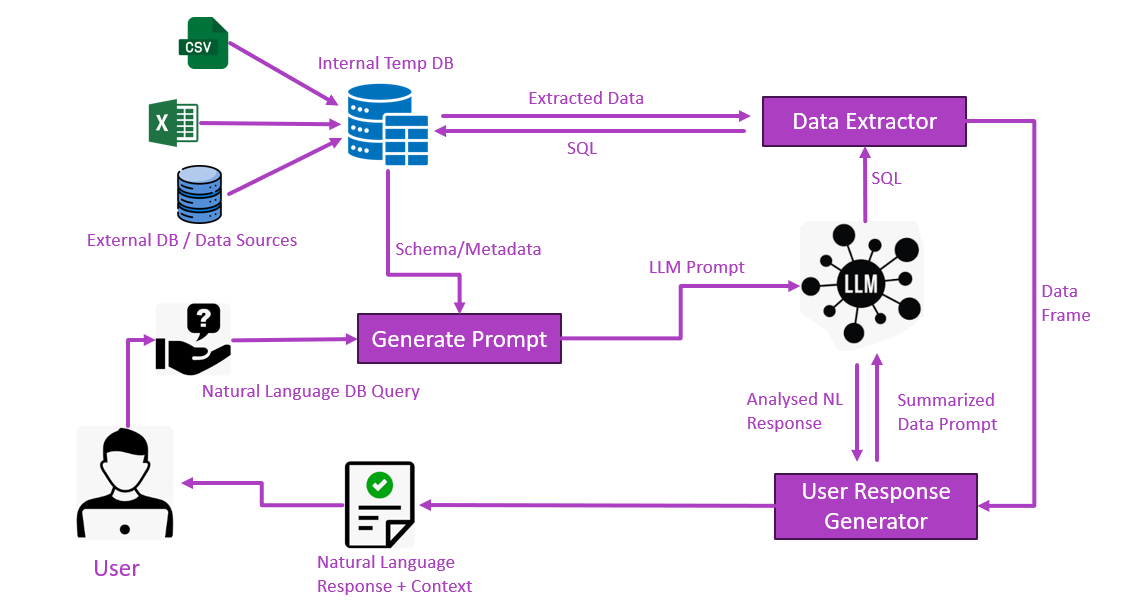

### 1. Data Cleanup and Loading

Convert data from our CSV into a DB file on which we can run SQL queries.<br>
Here we have given example of CSV file, this can be any type of source to load into internal temporary DB.

In [1]:
import sqlite3
import pandas as pd
import re

In [2]:
csv_file = 'repo.csv'
sqlite_db = 'database.db'
table_name = "repo_table"

In [3]:
def csv_to_sqlite(csv_file, sqlite_db, table_name):
    df = pd.read_csv(csv_file)
    # Format column names to be SQL-safe
    df.columns = [col.replace('%', ' percent') for col in df.columns]     # Replace % with "_percent" to maintain column meaning
    df.columns = [re.sub(r'[\[\]\(\)$%]', '', col.strip()) for col in df.columns]  # Remove [], (), $, %
    df.columns = [re.sub(r'\W+', '_', col.strip()) for col in df.columns]  # Replace non-alphanumeric characters with "_"
    conn = sqlite3.connect(sqlite_db)
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    conn.close()
    print(f'Data from {csv_file} has been successfully imported into {sqlite_db}')

In [4]:
csv_to_sqlite(csv_file, sqlite_db, table_name)

Data from repo.csv has been successfully imported into database.db


lets verify if database was created fine successfully

In [5]:
def verify_db_data(sqlite_db, table_name):
    conn = sqlite3.connect(sqlite_db)
    cursor = conn.cursor()
    query = f"SELECT * FROM {table_name} LIMIT 3"
    cursor.execute(query)
    rows = cursor.fetchall()
    conn.close()
    for row in rows:
        print(row)

verify_db_data(sqlite_db, table_name)

('RP 030725 2', 'Results', '03-07-2025', '03-07-2025', '03-10-2025', 'Repo', 'Multiple Price', 'Same Day', 3, 'Overnight', '1.30 PM', '1.45 PM', None, 500.0, None, None, 0.0, 0.0, 4.5, None, None, None, None, None, None, None, None, 0.0, 0.0, 4.5, None, None, None, None, None, None, None, None, 0.0, 0.0, 4.5, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 0.0, 0.0, '03-07-2025 13.45', None, None, None, None, None, None, None, None)
('RP 030625 2', 'Results', '03-06-2025', '03-06-2025', '03-07-2025', 'Repo', 'Multiple Price', 'Same Day', 1, 'Overnight', '1.30 PM', '1.45 PM', None, 500.0, None, None, 0.0, 0.0, 4.5, None, None, None, None, None, None, None, None, 0.0, 0.0, 4.5, None, None, None, None, None, None, None, None, 0.0, 0.0, 4.5, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 0.0, 0.0, '03-06-2025 13.45', None, None, None, None, None, None, None, 

In [6]:
# as we are working on Jupyter notebook, removing unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

### 2. Load LLM as core intelligence

To understand natural language, generating responses/SQL and analysing providing natural response we will be using locally running, free, open source LLM

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoConfig
import transformers
from transformers.utils import is_flash_attn_2_available

In [8]:
!nvidia-smi

Tue Mar 11 01:37:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   55C    P8             16W /  115W |    4544MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
import torch
torch.cuda.is_available()

True

As our hardware support CUDA GPU, this will make things faster

In [10]:
# For locally running
model_path = "../gemma/gemma-2-2b-it/"

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
model_id = model_path # (we are using locally downloaded LLM)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(model_path)


# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config,
                                                 attn_implementation=attn_implementation) # which attention version to use

#if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
#    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: ../gemma/gemma-2-2b-it/


`low_cpu_mem_usage` was None, now default to True since model is quantized.
Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]


In [11]:
# # For running on google colab

# #Private token, this will only be required if we are using non-local LLM
# import getpass
# access_token = getpass.getpass("insert HF access token")  # as we are loading notebook in google colab instead of local, we need to provide this

# model_id = "google/gemma-2-2b-it"
# dtype = torch.bfloat16

# tokenizer = AutoTokenizer.from_pretrained(model_id, token=access_token)
# llm_model = AutoModelForCausalLM.from_pretrained(
#     model_id,
#     device_map="cuda",
#     torch_dtype=dtype,
#     token=access_token
# )


In [12]:
llm_model

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2SdpaAttention(
          (q_proj): Linear4bit(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2304, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear4bit(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforward_layern

In [13]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 2192283136, 'model_mem_mb': 2090.72, 'model_mem_gb': 2.04}

Now that our LLM is loaded and works on our machine, lets generate text using LLM<br>
Generating prompt:<br>
For some LLMs you need to pass input in specific template to get the ideal output<br>
The model we are using "gemma-7b-it" has been trained in a dialog fashion (instruction tuning), for this we pass "dialogue_template" to tokenizer in method apply_chat_template"

In [14]:
input_text = "How many planets are in our solar system?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
How many planets are in our solar system?

Prompt (formatted):
<bos><start_of_turn>user
How many planets are in our solar system?<end_of_turn>
<start_of_turn>model



In [15]:
%%time

# Tokenize the input text and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   2299,   1767,  44797,    708,
            575,   1167,  12677,   1812, 235336,    107,    108,    106,   2516,
            108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   2299,   1767,  44797,    708,
           575,   1167,  12677,   1812, 235336,    107,    108,    106,   2516,
           108,   3493,    708,   5231,  40363,    688,  44797,    575,   1167,
         12677,   1812, 235265, 235248,    109,   4858,    984,    708,    575,
          2184,    774,    573,   7445, 235292,    109, 235274, 235265,   5231,
         82130,    688,    108, 235284, 235265,   5231,  98030,    688,    108,
        235304, 235265,   5231,  30962,    688,    108, 235310, 235265,   5231,
         48009,    688,    108, 235308, 235265,   5231, 124357,    

success.. lets convert above tokens to text to get our output

In [16]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
How many planets are in our solar system?<end_of_turn>
<start_of_turn>model
There are **eight** planets in our solar system. 

Here they are in order from the Sun:

1. **Mercury**
2. **Venus**
3. **Earth**
4. **Mars**
5. **Jupiter**
6. **Saturn**
7. **Uranus**
8. **Neptune**

Pluto was once considered the ninth planet, but it was reclassified as a dwarf planet in 2006. 
<end_of_turn>



Awesome, we got our nice and correct output text

In [17]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '').replace('<end_of_turn>', '')}")     # bos and eos are beginning and end of sentence

Input text: How many planets are in our solar system?

Output text:
There are **eight** planets in our solar system. 

Here they are in order from the Sun:

1. **Mercury**
2. **Venus**
3. **Earth**
4. **Mars**
5. **Jupiter**
6. **Saturn**
7. **Uranus**
8. **Neptune**

Pluto was once considered the ninth planet, but it was reclassified as a dwarf planet in 2006. 



### 3. Create SQL Prompts based on DB Schema

In [18]:
def run_sql_query(query):
    conn = sqlite3.connect(sqlite_db)
    result = pd.read_sql(query, conn)
    conn.close()
    return result

In [19]:
# lets verify data read from simple sql onto newly created database file
result_df = run_sql_query(f"SELECT * FROM {table_name} LIMIT 5")
print(result_df)

  Operation_Id Auction_Status Operation_Date Settlement_Date Maturity_Date  \
0  RP 030725 2        Results     03-07-2025      03-07-2025    03-10-2025   
1  RP 030625 2        Results     03-06-2025      03-06-2025    03-07-2025   
2  RP 030525 4        Results     03-05-2025      03-05-2025    03-06-2025   
3  RP 030525 6        Results     03-05-2025      03-05-2025    03-06-2025   
4  RP 030425 2        Results     03-04-2025      03-04-2025    03-05-2025   

  Operation_Type Operation_Method Settlement_Type  Term_Calendar_Days  \
0           Repo   Multiple Price        Same Day                   3   
1           Repo   Multiple Price        Same Day                   1   
2           Repo   Multiple Price        Same Day                   1   
3           Repo   Multiple Price        Same Day                   1   
4           Repo   Multiple Price        Same Day                   1   

        Term  ... Total_Amt_Accepted_Billions      Last_Updated  \
0  Overnight  ...        

lets get complete DB schema, which we'll need in our prompts

In [20]:
import json

def get_db_schema_json():
    """
    Extracts the schema from an SQLite database and returns it as a JSON string.
    """
    conn = sqlite3.connect(sqlite_db)
    cursor = conn.cursor()

    # Get list of tables
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()

    schema = {}

    for table in tables:
        table_name = table[0]
        cursor.execute(f"PRAGMA table_info({table_name});")
        columns = cursor.fetchall()
        schema[table_name] = [
            {"column_name": col[1], "data_type": col[2]} for col in columns
        ]

    conn.close()

    # Convert schema to JSON string
    schema_json = json.dumps(schema, indent=4)

    return schema_json

In [21]:
schema_json = get_db_schema_json()
schema_json

'{\n    "repo_table": [\n        {\n            "column_name": "Operation_Id",\n            "data_type": "TEXT"\n        },\n        {\n            "column_name": "Auction_Status",\n            "data_type": "TEXT"\n        },\n        {\n            "column_name": "Operation_Date",\n            "data_type": "TEXT"\n        },\n        {\n            "column_name": "Settlement_Date",\n            "data_type": "TEXT"\n        },\n        {\n            "column_name": "Maturity_Date",\n            "data_type": "TEXT"\n        },\n        {\n            "column_name": "Operation_Type",\n            "data_type": "TEXT"\n        },\n        {\n            "column_name": "Operation_Method",\n            "data_type": "TEXT"\n        },\n        {\n            "column_name": "Settlement_Type",\n            "data_type": "TEXT"\n        },\n        {\n            "column_name": "Term_Calendar_Days",\n            "data_type": "INTEGER"\n        },\n        {\n            "column_name": "Term",\n  

As we got our DB schema, this will be useful to provide in LLM prompt as context

In [22]:
# Generates a structured prompt for our LLM to convert a natural language query into SQL.

def generate_sql_prompt(user_query):
    prompt = f"""
    Convert the following natural language text user query into a SQlite SQL query using the given database schema.
    Column names in SQL must be from provided schema, for any errors or unrelated references return string QUERY_ERROR.

    ### Database Schema:
    {schema_json}

    ### User Query:
    "{user_query}"

    ### Output:
    Return only the SQL query, without any formatting and explanation.
    """
    return prompt.strip()

### 4. Generate SQL from natural language query

In [23]:
# lets create a global variable for setting debugging or stopping user spamming
DEBUG_MODE = False

In [24]:
def generate_llm_response(prompt):
    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=0.7,
                                 max_new_tokens=512)
    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])
    # Replace special tokens and unnecessary help message
    output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("<end_of_turn>", "")
    return output_text

In [25]:
generate_llm_response("what is apple ?")

"\n\nApple is a multinational technology company that designs, develops, and sells consumer electronics, computer software, and online services. \n\nHere's a breakdown of what they do:\n\n**Products:**\n\n* **Consumer Electronics:** iPhones, iPads, Macs, Apple Watches, AirPods, Apple TV\n* **Computer Software:** macOS, iOS, iPadOS, watchOS, tvOS\n* **Online Services:** Apple Music, iCloud, Apple Pay, App Store, Apple Arcade\n\n**Key Features:**\n\n* **User-friendly interface:** Apple products are known for their intuitive and easy-to-use interfaces.\n* **High-quality hardware and software:** Apple prioritizes the quality of its products, both in terms of hardware and software.\n* **Strong ecosystem:** Apple's products work seamlessly together, creating a strong ecosystem.\n* **Focus on privacy and security:** Apple places a high value on user privacy and security.\n* **Innovation:** Apple is constantly pushing the boundaries of technology and innovation.\n\n**History:**\n\n* Founded in

LLM is working as expected, lets try to generate SQL query now

In [26]:
import re

def generate_sql_query(query):
    # Format the prompt with context items
    prompt = generate_sql_prompt(query)
    if DEBUG_MODE: print("Prompt: ", prompt)

    output_text = generate_llm_response(prompt)

    # Replace special tokens and unnecessary help message
    output_text = re.sub(r"[\n`]", " ", output_text).strip()
    output_text = re.sub(r"^\s*sql\s*", "", output_text, flags=re.IGNORECASE)

    if "QUERY_ERROR" in output_text:
        return "QUERY_ERROR"

    if DEBUG_MODE: print("Query output: ", output_text)

    return output_text

In [27]:
generate_sql_query("give me first 5 rows")

'SELECT * FROM repo_table LIMIT 5;'

SQL query generated understood the context depending on schema and as it had single table it returned SQL for that

In [28]:
generate_sql_query("what is apple ?")

'QUERY_ERROR'

Nice!! we are able to get SQL queries from natural language query and with intelligence too

### 5. Extract data for provided query

In [29]:
user_query = "How many repo operations are present with 'Fixed Rate' method and 'Repo' type ?"

In [30]:
generate_sql_query(user_query)

"SELECT COUNT(*) FROM repo_table WHERE Operation_Type = 'Repo' AND Operation_Method = 'Fixed Rate';"

In [31]:
# this function will return extracted data as dataframe to be used later
def extract_dataframe(user_query):
    sql_query = generate_sql_query(user_query)
    if DEBUG_MODE: print(sql_query)
    if sql_query == 'QUERY_ERROR':
        return sql_query
    df = run_sql_query(sql_query)
    if DEBUG_MODE: print(df.head())
    return [df, sql_query]

In [32]:
op = extract_dataframe("show sum of all total amt accepted")
op[0]

,SUM(Total_Amt_Accepted_Billions)
0,5.488


Here, Now we are able to get pandas dataframe based on the natural query we provided. Some tech savvy people can use this as final function too to do additional operations on top of DF

In [33]:
# lets see what it did behind the scenes
DEBUG_MODE = True
(df, s) = extract_dataframe("show sum of all total amt accepted")
df

Prompt:  Convert the following natural language text user query into a SQlite SQL query using the given database schema.
    Column names in SQL must be from provided schema, for any errors or unrelated references return string QUERY_ERROR.

    ### Database Schema:
    {
    "repo_table": [
        {
            "column_name": "Operation_Id",
            "data_type": "TEXT"
        },
        {
            "column_name": "Auction_Status",
            "data_type": "TEXT"
        },
        {
            "column_name": "Operation_Date",
            "data_type": "TEXT"
        },
        {
            "column_name": "Settlement_Date",
            "data_type": "TEXT"
        },
        {
            "column_name": "Maturity_Date",
            "data_type": "TEXT"
        },
        {
            "column_name": "Operation_Type",
            "data_type": "TEXT"
        },
        {
            "column_name": "Operation_Method",
            "data_type": "TEXT"
        },
        {
           

,SUM(Total_Amt_Accepted_Billions)
0,5.488


In [34]:
#lets turn off debug mode for now
DEBUG_MODE = False

In [35]:
op = extract_dataframe("show average total amt accepted for 'Repo' operation")
op[0]

,AVG(Total_Amt_Accepted_Billions)
0,0.01372


### 6. Generate user response

Lets ask LLM to simplyfy and generate natural language response based on our extracted dataframe.<br>
To give context for verification we will provide SQL as context in response as well<br>
As we are working on small set of data this is fine, for large dataset you might wanna take different approach in your pipeline.

In [36]:
def generate_query_response(user_query):
    (df, sql_query) = extract_dataframe(user_query)
    df_text = df.to_json(orient="records", indent=2)  # JSON format (good for LLMs)

    prompt = f"""
    User asked: "{user_query}"

    The SQL query was executed, and here are the results:

    {df_text}

    Based on this data, provide a natural language answer to the user's question.
    """
    resp = generate_llm_response(prompt)

    # Remove excess newlines and spaces
    resp = re.sub(r'\n+', '\n', resp)  # Collapse multiple newlines into one
    resp = re.sub(r'\s+', ' ', resp).strip()  # Convert multiple spaces to one and strip leading/trailing spaces

    resp = f"""
    ### Model Response: {resp}

    ### Context SQL: {sql_query}
    """
    return resp

In [37]:
generate_query_response("How many operations were released at 8.15am ?")

"\n    ### Model Response: Answer: There were no operations released at 8:15am.\n\n    ### Context SQL: SELECT COUNT(*) FROM repo_table WHERE Release_Time = '2023-03-15 08:15:00';\n    "

From context SQL we can see that our query confuzed LLM and itstead of generic 8:30AM it took exact datetime of latest datetime "2023-03-15 08:30:00", so its best to show SQL query in context item, so user knows what he should be expecting

In [38]:
generate_query_response("How many operations were released at '8.15 AM' ?")

'\n    ### Model Response: Answer: "There were **5** operations released at 8:15 AM."\n\n    ### Context SQL: SELECT COUNT(*) FROM repo_table WHERE Release_Time = \'8.15 AM\';\n    '

In [39]:
# Lets verify
result_df = run_sql_query(f"SELECT COUNT(*) FROM repo_table WHERE Release_Time = '8.15 AM'")
print(result_df)

   COUNT(*)
0         5


In [40]:
generate_query_response("what was the tsy and agy minimum bid rate for operation id 'RP 011724 2'")

'\n    ### Model Response: Answer: The minimum bid rate for operation ID \'RP 011724 2\' was 5.5%.\n\n    ### Context SQL: SELECT          "Tsy_Minimum_Bid_Rate_percent"     FROM          "repo_table"     WHERE          "Operation_Id" = \'RP 011724 2\';\n    '

Awesome!! It understood even the partial combined column name

In [41]:
# lets verify
result_df = run_sql_query(f"SELECT Tsy_Minimum_Bid_Rate_percent, Agy_Minimum_Bid_Rate_percent FROM repo_table WHERE Operation_Id = 'RP 011724 2';")
print(result_df)


   Tsy_Minimum_Bid_Rate_percent  Agy_Minimum_Bid_Rate_percent
0                           5.5                           5.5


In [42]:
generate_query_response("Give me ID of operation having the lowest non-zero total amount submitted ?")

'\n    ### Model Response: Answer: The operation with the lowest non-zero total amount submitted is **RP 020625 2**.\n\n    ### Context SQL: SELECT Operation_Id FROM repo_table WHERE Total_Amt_Submitted_Billions > 0 ORDER BY Total_Amt_Submitted_Billions ASC LIMIT 1\n    '

Success!! We were able to successfully retrieve data based on natural language query provided by user.